In [1]:
import numpy as np
import pandas as pd

def generate_staggered_law_ar1_hetero_data(N, T, num_individuals, mean=0, std_dev=1):
    
    white_noise = np.random.normal(mean, std_dev, size=(N, num_individuals, T))  # Generating random white noise for each individual

    data = np.zeros((N, num_individuals, T))  # Initializing the array to store the data

    # state, time effects and rho for each state

    rhos = np.random.uniform(0.2,0.9, size = N)
    alphas = np.random.normal(0,1, size=N)
    betas = np.random.normal(0,1, size = T)

    # Generate the AR(1) process data for each individual
    
    for i in range(N):
        alpha = alphas[i]
        rho = rhos[i]
        for j in range(num_individuals):
            for t in range(T):
                beta = betas[t]
                if t == 0:
                    data[i, j, t] = alpha + beta + white_noise[i, j, t]
                else:
                    data[i, j, t] = alpha + beta + rho * data[i, j, t - 1] + white_noise[i, j, t]

 
    reshaped_data = data.reshape((N * num_individuals, T))     # Reshaping the data array for easier DataFrame creation

    
    df = pd.DataFrame(reshaped_data, columns=[f'{t}' for t in range(T)])  # Create a DataFrame with column names as time periods

    df['state'] = np.repeat(np.arange(1, N + 1), num_individuals)  # Add a new 'state' column with repeated state values

    df['individual'] = np.tile(np.arange(1, num_individuals + 1), N)  # Add a new 'individual' column with repeated individual values

    melted_df = pd.melt(df, id_vars=['state', 'individual'], var_name='time', value_name= 'value')

    melted_df['time'] = melted_df['time'].astype(int)  # Convert the 'time' column to int


    data = melted_df.copy()

    data['time'] = data['time'].astype(int)
    
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)  # Create state dummy variables

    state_dummies = state_dummies.astype(int)

    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True) # Create time dummy variables

    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)
   
    return data

Number of times null hypothesis is rejected for rho: 212 out of 5000 simulations
Type 1 Error: 0.0424
Bias for Coefficient of Treatment : 0.005783437330228406
MSE for Coefficient of Treatment : 1.3486089983314185
RMSE for Coefficient of Treatment : 1.1612962577789607
Average Standard Error: 0.5787117277331357
Standard Error of the beta_1 distribution: 0.5918990943322112
The confidence interval is (-1.1543387875609057, {1.1659056622213624})


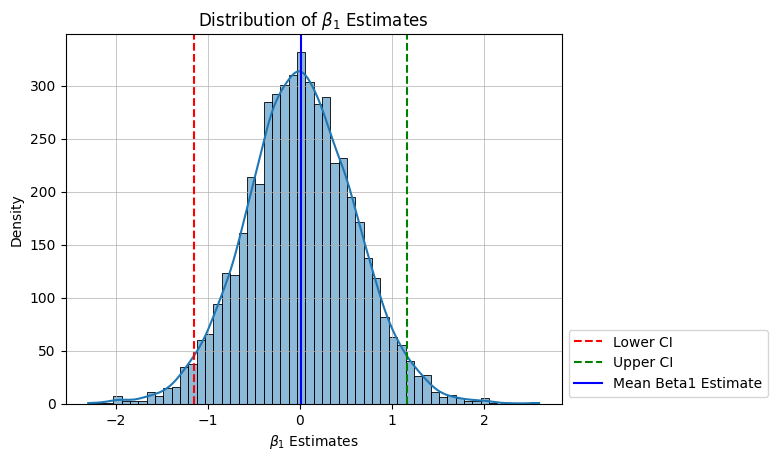

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


alpha = 0.05  # Significance level
num_simulations = 5000
num_individuals = 1
N = 20
T = 20

reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []

for _ in range(num_simulations):

    data = generate_staggered_law_ar1_hetero_data( N, T, num_individuals) # this time the data generation is inside the loop to ensure everytime new data is generated

    states = data['state'].unique()
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)   # To give the treatment to exactly half the states in a staggered approach

    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)  # Assigning treatment year to each treatment state, staggered between 5 and 15th time period

    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame
    
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

 
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']]
    
    X = sm.add_constant(X)
    Y = data['value'] 
    model = sm.OLS(Y, X).fit(cov_type='cluster', use_t = True,  cov_kwds={'groups': data['state'].astype(str)})

    bias_value = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias_value)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2
    squared_error_values.append(squared_error)
    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)

    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Checking  if null hypothesis for beta1 is rejected

    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

bias = np.mean(bias_values)
mse = np.mean(squared_error)   
rmse = np.sqrt(mse)  
average_standard_error = np.mean(standard_error_values)   
std_error_beta_distribution = np.std(beta1_estimates)

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected for rho: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.histplot(beta1_estimates, kde = True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()



